<a href="https://colab.research.google.com/github/mmotasim12/EE413-Image-Compression-Project/blob/main/EE413_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!unzip /content/drive/MyDrive/EE413/data.zip -d /content/


Archive:  /content/drive/MyDrive/EE413/data.zip
replace /content/data/test/n01532829/n0153282900000014.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
# Check first 10 class folders inside each directory
!echo "Train folder classes:"
!ls /content/data/train | head -10

!echo "\nTest folder classes:"
!ls /content/data/test | head -10

!echo "\nValidation folder classes:"
!ls /content/data/val | head -10

Train folder classes:
n01532829
n01558993
n01704323
n01749939
n01770081
n01843383
n01855672
n01910747
n01930112
n01981276
\nTest folder classes:
n01532829
n01558993
n01704323
n01749939
n01770081
n01843383
n01855672
n01910747
n01930112
n01981276
\nValidation folder classes:
n01532829
n01558993
n01704323
n01749939
n01770081
n01843383
n01855672
n01910747
n01930112
n01981276


In [8]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor()
])

train_path = '/content/data/train'
val_path = '/content/data/val'
test_path = '/content/data/test'

train_dataset = ImageFolder(train_path, transform=transform)
val_dataset = ImageFolder(val_path, transform=transform)
test_dataset = ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [9]:
import os

train_classes = set(os.listdir(train_path))
test_classes = set(os.listdir(test_path))

print("Train classes (first 10):", list(train_classes)[:10])
print("Test classes (first 10):", list(test_classes)[:10])

common_classes = train_classes.intersection(test_classes)
print(f"\nNumber of shared classes: {len(common_classes)} out of {len(train_classes)} training classes")


Train classes (first 10): ['n01981276', 'n03773504', 'n07584110', 'n03676483', 'n03347037', 'n07747607', 'n01843383', 'n02950826', 'n04258138', 'n02981792']
Test classes (first 10): ['n01981276', 'n03773504', 'n07584110', 'n03676483', 'n03347037', 'n07747607', 'n01843383', 'n02950826', 'n04258138', 'n02981792']

Number of shared classes: 100 out of 100 training classes


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 100)  # 100 classes in Mini-ImageNet
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
def train_model(model, train_loader, val_loader, epochs=3):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs} — Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

train_model(model, train_loader, val_loader, epochs=3)


Epoch 1/3 — Loss: 1278.4184, Accuracy: 55.05%
Epoch 2/3 — Loss: 829.9429, Accuracy: 69.14%
Epoch 3/3 — Loss: 559.2546, Accuracy: 78.17%


In [14]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

evaluate_model(model, test_loader)


Test Accuracy: 56.35%


56.35

In [15]:
!pip install PyWavelets


In [16]:
import pywt
import numpy as np
import torch
from torchvision.transforms import ToPILImage, ToTensor

to_pil = ToPILImage()
to_tensor = ToTensor()

def wavelet_compress_image(img_tensor, wavelet='haar', level=1, compression_ratio=0.1):
    """
    Compress a single image tensor using wavelet transform.
    img_tensor: PyTorch tensor of shape (C,H,W) with values [0,1]
    wavelet: type of wavelet (e.g., 'haar', 'db1')
    level: decomposition level (usually 1 or 2)
    compression_ratio: fraction of coefficients to keep (e.g., 0.1 means keep top 10%)
    """
    img_np = img_tensor.numpy()
    channels = []

    for c in range(img_np.shape[0]):
        coeffs = pywt.wavedec2(img_np[c], wavelet=wavelet, level=level)
        arr, coeff_slices = pywt.coeffs_to_array(coeffs)

        flat = np.abs(arr).flatten()
        thresh = np.percentile(flat, 100*(1-compression_ratio))
        arr_thresholded = np.where(np.abs(arr) >= thresh, arr, 0)

        coeffs_from_arr = pywt.array_to_coeffs(arr_thresholded, coeff_slices, output_format='wavedec2')
        compressed_c = pywt.waverec2(coeffs_from_arr, wavelet=wavelet)

        compressed_c = np.clip(compressed_c, 0, 1)
        compressed_c = compressed_c[:img_np.shape[1], :img_np.shape[2]]
        channels.append(compressed_c)

    compressed_img = np.stack(channels, axis=0)
    return torch.from_numpy(compressed_img.astype(np.float32))


In [17]:
from torch.utils.data import Dataset

class WaveletCompressedDataset(Dataset):
    def __init__(self, base_dataset, compression_ratio=0.1, wavelet='haar', level=1):
        self.base_dataset = base_dataset
        self.compression_ratio = compression_ratio
        self.wavelet = wavelet
        self.level = level

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]
        img_compressed = wavelet_compress_image(img, wavelet=self.wavelet,
                                                level=self.level,
                                                compression_ratio=self.compression_ratio)
        return img_compressed, label


In [18]:
compression_ratios = [0.1, 0.2, 0.5]  # Corresponds roughly to 10:1, 5:1, 2:1 compression

for ratio in compression_ratios:
    print(f"\nEvaluating at compression ratio: {ratio} (keep {int(ratio*100)}% coefficients)")

    compressed_test_dataset = WaveletCompressedDataset(test_dataset, compression_ratio=ratio)
    compressed_test_loader = DataLoader(compressed_test_dataset, batch_size=64, shuffle=False)

    acc = evaluate_model(model, compressed_test_loader)
    print(f"Accuracy at compression ratio {ratio}: {acc:.2f}%")



Evaluating at compression ratio: 0.1 (keep 10% coefficients)
Test Accuracy: 5.85%
Accuracy at compression ratio 0.1: 5.85%

Evaluating at compression ratio: 0.2 (keep 20% coefficients)
Test Accuracy: 23.25%
Accuracy at compression ratio 0.2: 23.25%

Evaluating at compression ratio: 0.5 (keep 50% coefficients)
Test Accuracy: 56.05%
Accuracy at compression ratio 0.5: 56.05%


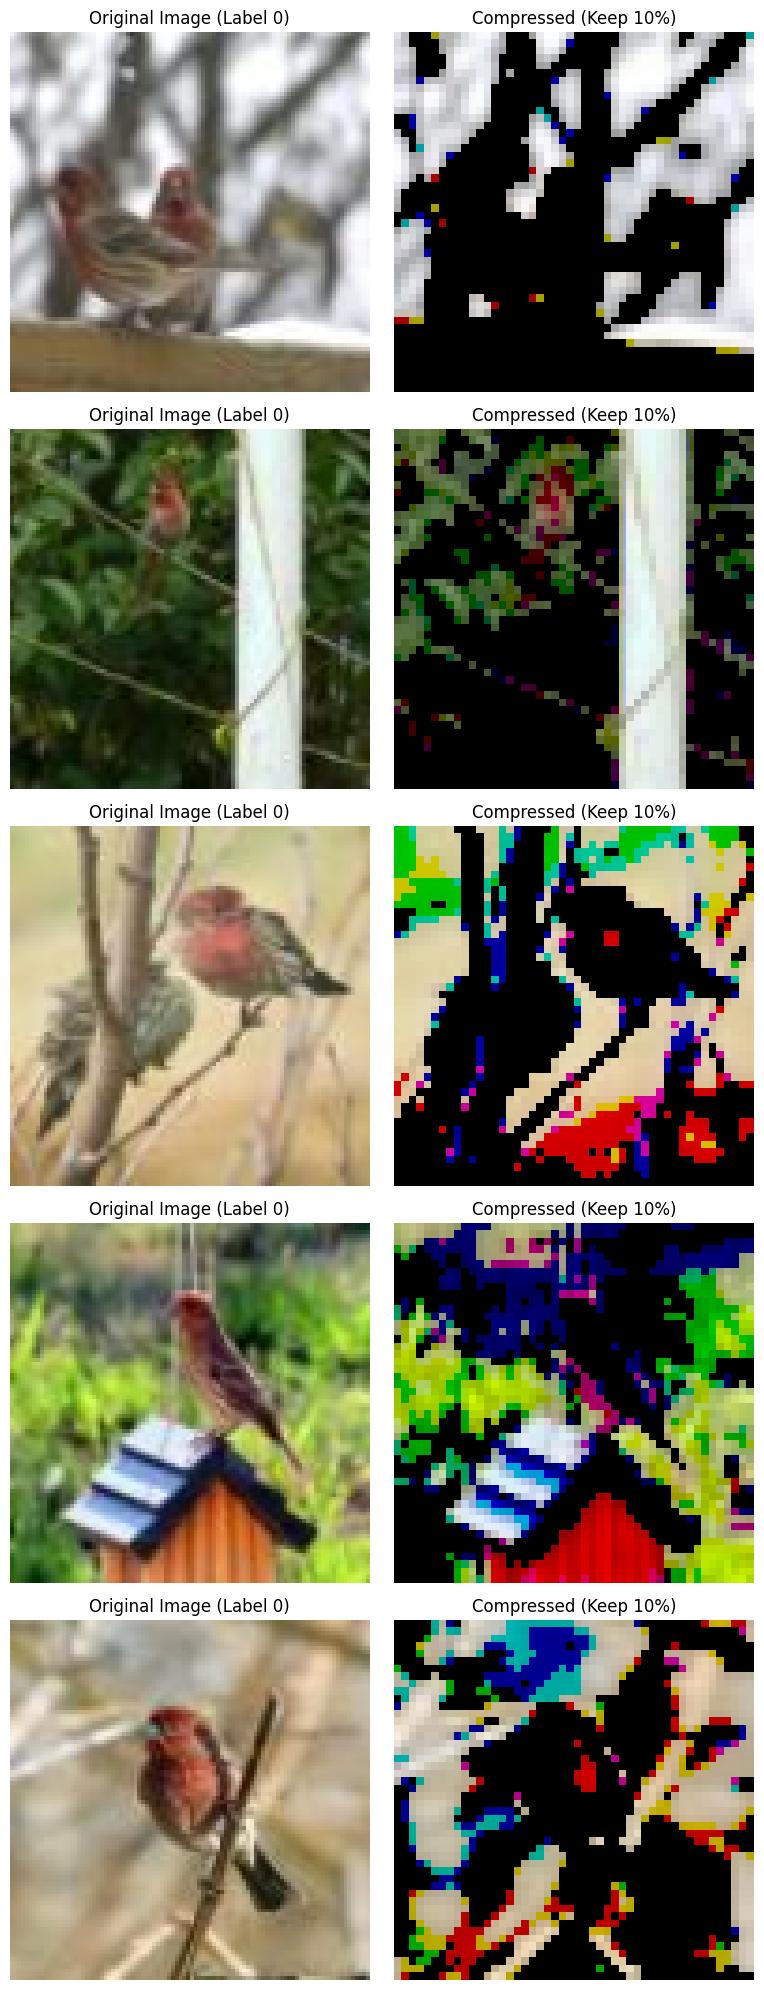

In [19]:
import matplotlib.pyplot as plt

def show_original_vs_compressed(dataset, compression_ratio=0.1, wavelet='haar', level=1, n_images=5):
    fig, axs = plt.subplots(n_images, 2, figsize=(8, 4*n_images))

    for i in range(n_images):
        img, label = dataset[i]
        compressed_img = wavelet_compress_image(img, wavelet=wavelet, level=level, compression_ratio=compression_ratio)

        # Convert tensors to numpy arrays for plotting
        img_np = img.permute(1, 2, 0).numpy()
        compressed_np = compressed_img.permute(1, 2, 0).numpy()

        axs[i, 0].imshow(img_np)
        axs[i, 0].set_title(f"Original Image (Label {label})")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(compressed_np)
        axs[i, 1].set_title(f"Compressed (Keep {int(compression_ratio*100)}%)")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
show_original_vs_compressed(test_dataset, compression_ratio=0.1)


In [20]:
class WaveletCompressedDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, compression_ratio=0.1, wavelet='haar', level=1):
        self.base_dataset = base_dataset
        self.compression_ratio = compression_ratio
        self.wavelet = wavelet
        self.level = level

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]
        img_compressed = wavelet_compress_image(img, wavelet=self.wavelet,
                                                level=self.level,
                                                compression_ratio=self.compression_ratio)
        return img_compressed, label


In [21]:
compression_ratios = [0.1, 0.2, 0.5]

compressed_train_loaders = {}
for ratio in compression_ratios:
    compressed_train_dataset = WaveletCompressedDataset(train_dataset, compression_ratio=ratio)
    loader = torch.utils.data.DataLoader(compressed_train_dataset, batch_size=64, shuffle=True)
    compressed_train_loaders[ratio] = loader


In [22]:
compression_ratio = 0.1
compressed_train_dataset = WaveletCompressedDataset(train_dataset, compression_ratio=compression_ratio)
compressed_train_loader = torch.utils.data.DataLoader(compressed_train_dataset, batch_size=64, shuffle=True)


In [23]:
def fine_tune_model(model, train_loader, val_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs} — Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Run fine-tuning for 5 epochs on compressed training data
fine_tune_model(model, compressed_train_loader, val_loader, epochs=3)

Epoch 1/3 — Loss: 1654.4132, Accuracy: 44.36%
Epoch 2/3 — Loss: 979.0945, Accuracy: 64.40%
Epoch 3/3 — Loss: 550.3955, Accuracy: 79.01%


In [24]:
compression_ratio = 0.1

# Create compressed test dataset and loader
compressed_test_dataset = WaveletCompressedDataset(test_dataset, compression_ratio=compression_ratio)
compressed_test_loader = torch.utils.data.DataLoader(compressed_test_dataset, batch_size=64, shuffle=False)

# Evaluate the model
evaluate_model(model, compressed_test_loader)

Test Accuracy: 40.23%


40.233333333333334

In [25]:
compression_ratio = 0.2
compressed_train_dataset = WaveletCompressedDataset(train_dataset, compression_ratio=compression_ratio)
compressed_train_loader = torch.utils.data.DataLoader(compressed_train_dataset, batch_size=64, shuffle=True)


In [26]:
# Re-initialize optimizer before fine-tuning
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

fine_tune_model(model, compressed_train_loader, val_loader, epochs=3)


Epoch 1/3 — Loss: 625.9131, Accuracy: 75.82%
Epoch 2/3 — Loss: 249.6745, Accuracy: 90.09%
Epoch 3/3 — Loss: 188.2532, Accuracy: 92.17%


In [27]:
compression_ratio = 0.2

compressed_test_dataset = WaveletCompressedDataset(test_dataset, compression_ratio=compression_ratio)
compressed_test_loader = torch.utils.data.DataLoader(compressed_test_dataset, batch_size=64, shuffle=False)

evaluate_model(model, compressed_test_loader)

Test Accuracy: 48.68%


48.68333333333333

In [28]:
compression_ratio = 0.5
compressed_train_dataset = WaveletCompressedDataset(train_dataset, compression_ratio=compression_ratio)
compressed_train_loader = torch.utils.data.DataLoader(compressed_train_dataset, batch_size=64, shuffle=True)


In [29]:
# Re-initialize optimizer before fine-tuning
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

fine_tune_model(model, compressed_train_loader, val_loader, epochs=3)


Epoch 1/3 — Loss: 225.9601, Accuracy: 90.60%
Epoch 2/3 — Loss: 118.9264, Accuracy: 95.03%
Epoch 3/3 — Loss: 126.0006, Accuracy: 94.80%


In [30]:
compressed_test_dataset = WaveletCompressedDataset(test_dataset, compression_ratio=compression_ratio)
compressed_test_loader = torch.utils.data.DataLoader(compressed_test_dataset, batch_size=64, shuffle=False)

evaluate_model(model, compressed_test_loader)


Test Accuracy: 53.90%


53.9

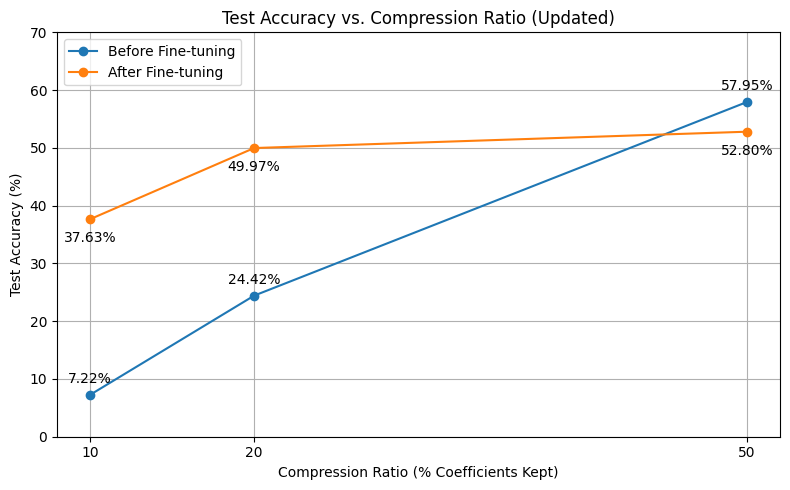

In [31]:
import matplotlib.pyplot as plt

# Compression ratios in % (coefficients kept)
compression_ratios = [10, 20, 50]

# Updated accuracy values (%)
accuracy_before = [7.22, 24.42, 57.95]
accuracy_after  = [37.63, 49.97, 52.80]

plt.figure(figsize=(8,5))
plt.plot(compression_ratios, accuracy_before, marker='o', label='Before Fine-tuning')
plt.plot(compression_ratios, accuracy_after, marker='o', label='After Fine-tuning')

# Show value labels on each point
for x, y in zip(compression_ratios, accuracy_before):
    plt.text(x, y + 2, f"{y:.2f}%", ha='center', fontsize=10)

for x, y in zip(compression_ratios, accuracy_after):
    plt.text(x, y - 4, f"{y:.2f}%", ha='center', fontsize=10)

plt.title('Test Accuracy vs. Compression Ratio (Updated)')
plt.xlabel('Compression Ratio (% Coefficients Kept)')
plt.ylabel('Test Accuracy (%)')
plt.xticks(compression_ratios)
plt.ylim(0, 70)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [44]:
import random
from torch.utils.data import Subset

# Fix seed for reproducibility
random.seed(42)

subset_indices = random.sample(range(len(test_dataset)), 20)
test_subset = Subset(test_dataset, subset_indices)


In [45]:
import numpy as np

def create_measurement_matrix(m, n):
    """
    Create a random Gaussian measurement matrix of size m x n.
    """
    return np.random.randn(m, n) / np.sqrt(m)


In [46]:
def compress_image_cs(img_tensor, Phi):
    """
    img_tensor: torch tensor shape (C,H,W), values [0,1]
    Phi: measurement matrix shape (m, n)
    Returns compressed measurements y of shape (m,)
    """
    img_np = img_tensor.numpy().flatten()  # Flatten to 1D vector length n
    y = Phi @ img_np  # Matrix multiply to get compressed measurements
    return y


In [47]:
!pip install cvxpy


In [36]:
import cvxpy as cp

def reconstruct_image_cs(y, Phi, img_shape):
    """
    Reconstruct image from compressed measurements y using L1 minimization.
    img_shape: (C,H,W)
    Returns reconstructed image numpy array of shape img_shape
    """
    n = Phi.shape[1]
    x = cp.Variable(n)
    objective = cp.Minimize(cp.norm1(x))
    constraints = [Phi @ x == y]
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)

    x_reconstructed = x.value
    if x_reconstructed is None:
        x_reconstructed = np.zeros(n)  # fallback

    return x_reconstructed.reshape(img_shape)


In [37]:
def compressed_sensing_pipeline(img_tensor, sampling_rate):
    C, H, W = img_tensor.shape
    n = C * H * W
    m = int(sampling_rate * n)
    Phi = create_measurement_matrix(m, n)
    y = compress_image_cs(img_tensor, Phi)
    x_rec = reconstruct_image_cs(y, Phi, img_tensor.shape)
    x_rec = np.clip(x_rec, 0, 1)
    x_rec_tensor = torch.from_numpy(x_rec.astype(np.float32))
    return x_rec_tensor


In [38]:
class CompressedSensingDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, sampling_rate=0.5):
        self.base_dataset = base_dataset
        self.sampling_rate = sampling_rate

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]
        img_rec = compressed_sensing_pipeline(img, self.sampling_rate)
        return img_rec, label


In [39]:
import torchvision.transforms as transforms

resize_transform = transforms.Resize((32, 32))
to_pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()

def compressed_sensing_pipeline_downsample(img_tensor, sampling_rate):
    img_small = resize_transform(to_pil(img_tensor)).convert('RGB')
    img_small_tensor = to_tensor(img_small)
    return compressed_sensing_pipeline(img_small_tensor, sampling_rate)


In [48]:
class CompressedSensingDatasetDownsample(torch.utils.data.Dataset):
    def __init__(self, base_dataset, sampling_rate=0.5):
        self.base_dataset = base_dataset
        self.sampling_rate = sampling_rate

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]
        img_rec = compressed_sensing_pipeline_downsample(img, self.sampling_rate)
        return img_rec, label


In [41]:
from torch.utils.data import Subset
import random

random.seed(42)
subset_indices = random.sample(range(len(test_dataset)), 5)  # smaller subset
test_subset = Subset(test_dataset, subset_indices)

cs_dataset = CompressedSensingDatasetDownsample(test_subset, sampling_rate=0.5)


In [42]:
cs_loader = torch.utils.data.DataLoader(cs_dataset, batch_size=1, shuffle=False)


In [43]:
accuracy = evaluate_model(model, cs_loader)
print(f"Test Accuracy on compressed sensing reconstructed images: {accuracy:.2f}%")


Test Accuracy: 0.00%
Test Accuracy on compressed sensing reconstructed images: 0.00%


In [ ]:
import gc
import torch

sampling_rates = [0.25, 0.5, 0.75]

for rate in sampling_rates:
    print(f"\nEvaluating with sampling rate: {rate}")

    cs_dataset = CompressedSensingDataset(test_subset, sampling_rate=rate)
    cs_loader = torch.utils.data.DataLoader(cs_dataset, batch_size=1, shuffle=False)

    acc = evaluate_model(model, cs_loader)
    print(f"Accuracy at sampling rate {rate}: {acc:.2f}%")

    # Cleanup to free memory before next iteration
    del cs_dataset, cs_loader
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()



Evaluating with sampling rate: 0.25
